# THIES Binary Processor

THIES DL16 exports two types of data in two different directories: 
* `ARCH_AV1` for avarage values of a 10 min span. Consists of 19 parameters of DataType Float.
* `ARCH_EX1` for both min and max values measured within the 10 min span. Consists of 32 parameters of DataType FloatExtrem.

There is a file for each day measured. File names are in `YYYYMMDD.BIN` format.

In [20]:
import os
import numpy as np
from bitarray import bitarray
import pandas as pd
import configparser
import struct

In [6]:
# Size of row (bytes)
AV_ROW_SIZE = 99
EX_ROW_SIZE = 292
# Size (n of parameters)
AV_DESC_SIZE = 19
EX_DESC_SIZE = 32
# First 4 bytes are DATETIME
OFFSET = 4 
STATUS_CHAR = {0b00000000 : 0,  # Status OK
              0b10000000 : '-', # Sensor is deactivated in the sensor configuration
              0b01000000 : '-', # Datalogger is in maintenance mode
              0b00100000 : '%', # Timeout (for ex. digitalization takes too long)
              0b00010000 : '!', # Value is out of valid range
              0b00001000 : '@', # Difference between 2 consecutive values is too far
              0b00000100 : '#', # Filling level of the averaging buffer is too low
              0b00000010 : '?', # Error depending on measurement type (for ex. ADC overflow)
              0b00000001 : '?'} # Error depending on measurement type (for ex. cable break)

In [94]:
path_bin_av = './BINFILES/ARCH_AV1/20240601.BIN'
path_bin_ex = './BINFILES/ARCH_EX1/20240601.BIN'
path_ini_av = './BINFILES/ARCH_AV1/DESCFILE.INI'
path_ini_ex = './BINFILES/ARCH_EX1/DESCFILE.INI'

### Aux functions

In [146]:
def read_descfile(path) -> dict:
        ''' 
        Input: path DESCFILE.INI
        Returns: dict 
            key is index [i]
            value is dict with parameters from .ini
        '''
        if type(path) == dict:
            return path
        config = configparser.ConfigParser()
        config.read(path)
        data_dict = {}
        for section in config.sections():
            section_dict = dict(config.items(section))
            data_dict[int(section)] = section_dict
        return data_dict

def format_dt(datetime: str, date: bool, time: bool) -> str:
    '''
    Input: str "YYYY/MM/DD hh:mm:ss"
    Returns: str
    - YYYY/MM/DD (True, False), or
    - hh:mm (False, True), or
    - YYYY/MM/DD hh:mm (True, True), or
    - empty str (False, False)
    '''
    datelist = datetime.split()
    return datelist[0]*date + ' '*date*time + datelist[1][:5]*time

## Class THIESDayData


In [110]:
class THIESDayData:
    # Bytes per row
    BPR = {'av': 99, 'ex': 292}
    # Parameters per row
    PPR = {'av': 19, 'ex': 32}
    # Bytes per parameter
    BPP = {'av': 5, 'ex': 9}
    # Timestamp Offset
    OFFSET = 4

    def __init__(self, datatype: str) -> None:
        d = datatype.lower().strip()
        if d not in ['av', 'ex']:
            raise ValueError(
                "Invalid datatype. Expected 'av' (average values) or 'ex' (minmax values).")

        self._bpr = THIESDayData.BPR[d]
        self._bpp = THIESDayData.BPP[d]
        self._datatype = d
        self._binfile = None
        self.descfile = {}
        self.nparameters = -1
        self.nbytes = -1
        self.nrows = -1
        self.statusDF = pd.DataFrame()
        self.dataDF = pd.DataFrame()
        self.datesDF = pd.DataFrame()
        
        self._date = ''


    @staticmethod
    def _bytes2datetime(b: bytes, only_time:bool=False) -> str:
        '''
        Input: bytes (size 4)
        Output: str (YYYY/MM/DD hh:mm:ss)
        '''
        bits = bitarray()
        bits.frombytes(b[::-1])  # Invert 4 bytes
        hr = int(bits[15:20].to01(), 2)
        min = int(bits[20:26].to01(), 2)
        sec = int(bits[26:].to01(), 2)
        time = f'{str(hr).zfill(2)}:{str(min).zfill(2)}'
        if only_time:
            return time
        yr = int(bits[0:6].to01(), 2)
        mon = int(bits[6:10].to01(), 2)
        day = int(bits[10:15].to01(), 2)
        date = f'20{yr}/{str(mon).zfill(2)}/{str(day).zfill(2)}'
        return date + ' ' + time + f':{str(sec).zfill(2)}'

    def read_binfile(self, binpath: str, inipath: str) -> None:
        with open(binpath, "rb") as bin_file:
            binfile = bin_file.read()
        self._binfile = binfile
        self.nbytes = len(self._binfile)
        self.nrows = int(self.nbytes / self._bpr)
        self.descfile = read_descfile(inipath)
        self.nparameters = len(self.descfile)
        self._make_dataframes()

    def _make_dataframes(self) -> None:
        '''
        Builds data DF, status DF and, if datatype=ex, dates DF.
        '''
        byterows = [self._binfile[i*self._bpr +
                                  THIESDayData.OFFSET: (i+1)*self._bpr] for i in range(0, self.nrows)]
        data_arr = np.zeros((self.nrows, self.nparameters))
        status_arr = np.zeros((self.nrows, self.nparameters))
        timestamp_arr = np.empty(self.nrows, dtype=object)
        dates_arr = np.empty((self.nrows, self.nparameters), dtype=object)

        for i, row in enumerate(byterows):
            # Timestamp
            ts_bytes = self._binfile[i*self._bpr:i*self._bpr + 4]
            ts = THIESDayData._bytes2datetime(ts_bytes)
            timestamp_arr[i] = ts

            for j in range(self.nparameters):
                # Status = byte 1
                status = row[j*self._bpp]
                status_arr[i, j] = status

                # Value = bytes 2-5, float
                value = struct.unpack(
                    '<f', row[j*self._bpp+1: j*self._bpp+5])[0]
                data_arr[i, j] = round(value, 1)

                if self._datatype == 'ex':
                    # Datetime = bytes 6-9
                    datetime = THIESDayData._bytes2datetime(
                        row[j*self._bpp + 5: j*self._bpp + 9], only_time=True)
                    dates_arr[i, j] = datetime

        self.dataDF = pd.DataFrame(data_arr).rename(
            columns={i: self.descfile[i+1]['name'] for i in range(self.nparameters)})
        self.statusDF = pd.DataFrame(status_arr).rename(
            columns={i: self.descfile[i+1]['name'] for i in range(self.nparameters)})
        self.dataDF = self.dataDF.where(self.statusDF == 0.0, other=None)

        if self._datatype == 'ex':
            self.datesDF = pd.DataFrame(dates_arr).rename(
                columns={i: self.descfile[i+1]['name'] for i in range(self.nparameters)})
            self.datesDF = self.datesDF.where(self.statusDF == 0.0, other=None)
            self.datesDF.index = timestamp_arr

        # Add timestamps as index
        self.dataDF.index = timestamp_arr
        self.statusDF.index = timestamp_arr
    
    @property
    def date(self) -> str:
        ''' 
        Returns str of date of measurement
        '''
        if len(self.dataDF) and self._date == '':
            self._date = self.dataDF.index[0].split(' ')[0]
        return self._date
    
    @property
    def shape(self):
        return self.dataDF.shape
    
    def write_csv(self, filename: str) -> None:
        with open(filename, 'w') as outfile:
            outfile.write(self.dataDF.to_csv())


    def __repr__(self) -> str:
        return str(self.dataDF)

    def _repr_html_(self):
        return self.dataDF._repr_html_()

    def __len__(self):
        return len(self.dataDF)

    def __add__(self, other):
        if isinstance(other, THIESDayData):
            new = THIESDayData(datatype=self._datatype)
            new.descfile = self.descfile
            new.nparameters = len(new.descfile)
            new.nrows = self.nrows + other.nrows
            new.nbytes = self.nbytes + other.nbytes
            new.statusDF = pd.concat([self.statusDF, other.statusDF])
            new.dataDF = pd.concat([self.dataDF, other.dataDF])
            if self._datatype == 'ex':
                new.datesDF = pd.concat([self.datesDF, other.datesDF])
            return new
        raise TypeError(
            f"unsupported operand type(s) for +: 'THIESDayData' and '{type(other)}'")

## Example 1: 2024/05/31 AV files

In [112]:
data1 = THIESDayData('av')
data1.read_binfile(path_bin_av, path_ini_av)

data1.dataDF


,UBat,Pressure,PrTemp,Precipitation,WS,WD,WS std. dev.,WD std. dev.,Humidity,AirTemperature,Radiation,PicoMoisture 1,PicoSoilTemp 1,PicoMoisture 2,PicoSoilTemp 2,CO2,UVA Radiation,UVB Radiation,PAR Radiation
2024/06/01 00:00:00,11.6,1009.8,5.6,0,1.3,87.2,0.4,28.3,100,3.5,-0.2,None,None,None,None,447.1,-0.1,0.0,-0.8
2024/06/01 00:10:00,11.6,1009.9,5.8,0,0.8,356.2,0.4,83.3,100,3.7,-0.1,None,None,None,None,446.5,-0.1,0.0,-0.8
2024/06/01 00:20:00,11.6,1009.9,5.9,0,0.8,272.7,0.3,84.2,100,3.8,-0.0,None,None,None,None,448.9,-0.1,0.0,-0.8
2024/06/01 00:30:00,11.6,1010.1,6.0,0,0.7,45.7,0.3,66.6,100,3.8,-0.0,None,None,None,None,457.7,-0.1,0.0,-0.7
2024/06/01 00:40:00,11.6,1010.0,6.1,0,0.1,52.6,0.2,59.0,100,3.7,-0.1,None,None,None,None,463.2,-0.1,0.0,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024/06/01 23:10:00,12.8,1020.4,3.2,0,0.7,43.1,0.2,39.9,100,0.0,-0.9,None,None,None,None,453.2,-0.1,0.0,-1.0
2024/06/01 23:20:00,12.8,1020.4,3.2,0,0.5,31.1,0.2,41.4,100,-0.0,-1.1,None,None,None,None,453.3,-0.1,0.0,-1.0
2024/06/01 23:30:00,12.8,1020.7,3.1,0,0.3,48.7,0.3,60.4,100,-0.2,-0.4,None,None,None,None,451.7,-0.1,0.0,-1.0
2024/06/01 23:40:00,12.8,1020.8,3.1,0,0.5,40.5,0.2,13.3,100,-0.3,-0.2,None,None,None,None,453.3,-0.1,0.0,-1.0


## Example 2: 2024/05/31 [EX files](https://www.youtube.com/watch?v=v4-GcS1UQyg)

In [113]:
data2 = THIESDayData('ex')
data2.read_binfile(path_bin_ex, path_ini_ex)
data2

,UBat MIN,UBat MAX,Pressure MIN,Pressure MAX,PrTemp MIN,PrTemp MAX,WS MIN,WS MAX gust,WD MIN,WD MAX gust,...,PicoSoilTemp 2 MIN,PicoSoilTemp 2 MAX,CO2 MIN,CO2 MAX,UVA Radiation MIN,UVA Radiation MAX,UVB Radiation MIN,UVB Radiation MAX,PAR Radiation MIN,PAR Radiation MAX
2024/06/01 00:00:00,11.6,11.6,1009.6,1010.0,5.6,5.7,0.6,2.5,95.0,85.0,...,None,None,438.5,461.8,-0.1,-0.1,-0.0,-0.0,-0.8,-0.7
2024/06/01 00:10:00,11.6,11.6,1009.7,1010.0,5.7,5.9,0.3,1.6,207.5,70.9,...,None,None,433.0,462.0,-0.1,-0.1,-0.0,-0.0,-0.8,-0.7
2024/06/01 00:20:00,11.6,11.6,1009.8,1010.2,5.8,6.0,0.3,1.7,327.5,14.3,...,None,None,432.6,459.7,-0.1,-0.1,-0.0,-0.0,-0.8,-0.7
2024/06/01 00:30:00,11.6,11.6,1009.9,1010.2,6.0,6.1,0.0,1.2,0.0,20.0,...,None,None,448.9,466.4,-0.1,-0.1,-0.0,-0.0,-0.8,-0.7
2024/06/01 00:40:00,11.6,11.6,1009.9,1010.2,6.0,6.1,0.0,0.5,0.0,336.7,...,None,None,456.8,469.2,-0.1,-0.1,-0.0,-0.0,-0.8,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024/06/01 23:10:00,12.8,12.8,1020.2,1020.6,3.2,3.2,0.3,1.1,352.5,44.2,...,None,None,448.9,458.1,-0.1,-0.1,-0.0,-0.0,-1.1,-1.0
2024/06/01 23:20:00,12.8,12.8,1020.2,1020.7,3.1,3.2,0.0,0.9,0.0,16.6,...,None,None,449.1,457.5,-0.1,-0.1,-0.0,-0.0,-1.1,-1.0
2024/06/01 23:30:00,12.8,12.8,1020.5,1020.8,3.1,3.2,0.0,1.0,0.0,26.7,...,None,None,446.8,456.9,-0.1,-0.1,-0.0,-0.0,-1.1,-1.0
2024/06/01 23:40:00,12.8,12.8,1020.6,1021.0,3.0,3.1,0.3,0.9,47.5,36.6,...,None,None,448.4,457.9,-0.1,-0.1,-0.0,-0.0,-1.1,-1.0


In [51]:
# At what time was the MAX/MIN measurment taken (hh:mm)
data2.datesDF

,UBat MIN,UBat MAX,Pressure MIN,Pressure MAX,PrTemp MIN,PrTemp MAX,WS MIN,WS MAX gust,WD MIN,WD MAX gust,...,PicoSoilTemp 2 MIN,PicoSoilTemp 2 MAX,CO2 MIN,CO2 MAX,UVA Radiation MIN,UVA Radiation MAX,UVB Radiation MIN,UVB Radiation MAX,PAR Radiation MIN,PAR Radiation MAX
2024/07/28 11:50:00,11:49,11:49,11:49,11:49,11:49,11:49,None,None,None,None,...,11:49,11:49,11:49,11:49,11:49,11:49,11:49,11:49,11:49,11:49
2024/07/28 12:00:00,11:53,11:50,11:56,11:57,11:50,11:58,11:55,11:52,11:55,11:52,...,None,None,11:50,11:58,11:52,11:59,11:52,11:56,11:55,11:50
2024/07/28 12:10:00,12:09,12:02,12:05,12:04,12:00,12:09,12:06,12:00,12:06,12:00,...,None,None,12:03,12:06,12:00,12:02,12:04,12:02,12:06,12:02
2024/07/28 12:20:00,12:10,12:10,12:13,12:17,12:10,12:17,12:12,12:18,12:12,12:18,...,None,None,12:12,12:18,12:10,12:10,12:10,12:10,12:10,12:10
2024/07/28 12:30:00,12:29,12:20,12:27,12:23,12:20,12:26,12:29,12:28,12:29,12:28,...,None,None,12:20,12:23,12:20,12:30,12:25,12:29,12:26,12:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024/07/28 23:10:00,23:02,23:00,23:05,23:08,23:09,23:00,23:07,23:10,23:07,23:10,...,None,None,23:02,23:09,23:00,23:03,23:00,23:07,23:00,23:06
2024/07/28 23:20:00,23:12,23:10,23:10,23:14,23:16,23:10,23:17,23:13,23:17,23:13,...,None,None,23:14,23:10,23:14,23:19,23:14,23:18,23:15,23:19
2024/07/28 23:30:00,23:21,23:20,23:25,23:29,23:27,23:20,23:20,23:28,23:20,23:28,...,None,None,23:24,23:26,23:21,23:26,23:21,23:27,23:21,23:27
2024/07/28 23:40:00,23:30,23:31,23:30,23:38,23:36,23:30,23:39,23:36,23:39,23:36,...,None,None,23:39,23:37,23:39,23:31,23:38,23:35,23:34,23:34


## Class THIESData

In [75]:
class THIESData:

    def __init__(self, datatype: str, dirpath: str) -> None:
        d = datatype.lower().strip()
        if d not in ['av', 'ex']:
            raise ValueError(
                "Invalid datatype. Expected 'av' (average values) or 'ex' (minmax values).")

        self._path = dirpath
        self._datatype = d
        self.filelist = []
        self.size = 0
        self.descfile = {} 

        self.verify_path(dirpath)

        self.daylist = []
        self.fullData = pd.DataFrame()

        self.read_folder()
    
    def verify_path(self, path: str) -> None:
        fl = sorted(os.listdir(path))
        if 'DESCFILE.INI' not in fl:
            raise FileNotFoundError('No DESCFILE.INI found in this directory.')
        self.filelist = fl[:-1]
        self.size = len(self.filelist)

    def read_folder(self):
        descpath = self._path + '/DESCFILE.INI'
        self.descfile = read_descfile(descpath)
        for f in self.filelist:
            filepath = f'{self._path}/{f}'
            daydata = THIESDayData(datatype=self._datatype)
            daydata.read_binfile(binpath=filepath, inipath=self.descfile)
            self.daylist.append(daydata)

        self.fullData = sum(self.daylist, start=THIESDayData(self._datatype))
        return self.fullData

    def write_csv(self, filename: str) -> None:
        # if self._datatype == 'av':
        self.fullData.write_csv(filename + '.csv')
        print(f'Done! Data written in: {filename}.csv')

    def __repr__(self) -> str:
        return str(self.fullData)

    def _repr_html_(self):
        return self.fullData

In [76]:
bigdata = THIESData('av', './BINFILES/ARCH_AV1')


# Visualizations

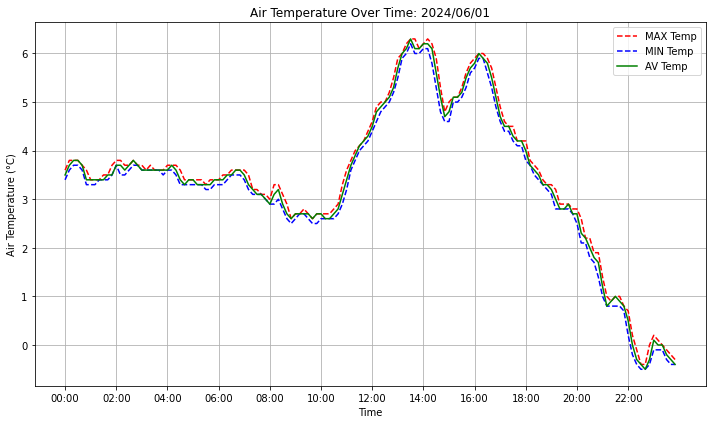

In [139]:
import matplotlib.pyplot as plt
        
df = data1.dataDF
df2 = data2.dataDF

idx = [format_dt(i, False, True)for i in df.index]

plt.figure(figsize=(10, 6))
plt.plot(idx, df2['AirTemperature MAX'], linestyle='--', color='r', label='MAX Temp')
plt.plot(idx, df2['AirTemperature MIN'], linestyle='--', color='b', label='MIN Temp')
plt.plot(idx, df['AirTemperature'], linestyle='-', color='g', label='AV Temp')
plt.title(f'Air Temperature Over Time: {data1.date}')
plt.xlabel('Time')
plt.ylabel('Air Temperature (°C)')

num_dates_to_show = 12
plt.xticks(idx[::len(df)//num_dates_to_show], rotation=0)  # Show every n-th date

plt.grid()
plt.legend()
plt.tight_layout()
plt.show()